# Noise Process of BP network associated with 2004 Parkfield earthquake 

Feburary 10, 2020 Kurama Okubo

# Package installatoin

Install packages and checkout branches as they are under development.
We will eventually publish a unified package.

In [1]:
using Pkg

In [2]:
using Distributed
NP = 2 # number of processes you use for parallelization with pmap
Distributed.addprocs(NP)

2-element Array{Int64,1}:
 2
 3

In [3]:
# @everywhere using IJulia
# IJulia.installkernel("Julia nodeps", "--depwarn=no")

In [4]:
#precompiling packages at every processors. this takes ~5 minutes.
@everywhere using SeisIO, SeisNoise, SeisDownload, SeisRemoveEQ, SeisXcorrelation, SeisDvV, SeisNetwork
using JLD2, Printf, Dates

┌ Info: Recompiling stale cache file /Users/kurama/.julia/compiled/v1.2/SeisNoise/7HCX4.ji for SeisNoise [8cc7c3c0-6b5d-11e9-39fe-c9cd0236e08b]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/kurama/.julia/compiled/v1.2/SeisRemoveEQ/Vg058.ji for SeisRemoveEQ [ee8e518e-a107-11e9-1e00-0b6f0be20652]
└ @ Base loading.jl:1240
┌ Warning: Module SeisNoise with build ID 49629929616228 is missing from the cache.
│ This may mean SeisNoise [8cc7c3c0-6b5d-11e9-39fe-c9cd0236e08b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1000
┌ Info: Skipping precompilation since __precompile__(false). Importing SeisRemoveEQ [ee8e518e-a107-11e9-1e00-0b6f0be20652].
└ @ Base loading.jl:1017
┌ Info: Recompiling stale cache file /Users/kurama/.julia/compiled/v1.2/SeisXcorrelation/UewSy.ji for SeisXcorrelation [f575b828-86f4-11e9-2d31-dfa2128ce4de]
└ @ Base loading.jl:1240
┌ Warning: Module SeisNoise with build ID 49629929616228 is missing from the ca

      From worker 3:	WARNING: Method definition remove_nanandzerocol(AbstractArray{T, N} where N where T) in module SeisXcorrelation at /Users/kurama/.julia/dev/SeisXcorrelation/src/utils.jl:13 overwritten at /Users/kurama/.julia/dev/SeisXcorrelation/src/utils.jl:13.
      From worker 3:	  ** incremental compilation may be fatally broken for this module **
      From worker 3:	
      From worker 2:	WARNING: Method definition remove_nanandzerocol(AbstractArray{T, N} where N where T) in module SeisXcorrelation at /Users/kurama/.julia/dev/SeisXcorrelation/src/utils.jl:13 overwritten at /Users/kurama/.julia/dev/SeisXcorrelation/src/utils.jl:13.
      From worker 2:	  ** incremental compilation may be fatally broken for this module **
      From worker 2:	
      From worker 3:	┌ Warning: Replacing docs for `SeisXcorrelation.remove_nanandzerocol :: Tuple{AbstractArray}` in module `SeisXcorrelation`
      From worker 3:	└ @ Base.Docs docs/Docs.jl:223
      From worker 3:	WARNING: Method defin

┌ Info: Recompiling stale cache file /Users/kurama/.julia/compiled/v1.2/SeisDvV/Mw8TT.ji for SeisDvV [e40d110b-8dd0-4233-8bb6-ca75ec97d0fb]
└ @ Base loading.jl:1240
┌ Warning: Module Interpolations with build ID 49634871006800 is missing from the cache.
│ This may mean Interpolations [a98d9a8b-a2ab-59e6-89dd-64a1c18fca59] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1000
┌ Info: Skipping precompilation since __precompile__(false). Importing SeisDvV [e40d110b-8dd0-4233-8bb6-ca75ec97d0fb].
└ @ Base loading.jl:1017
┌ Info: Recompiling stale cache file /Users/kurama/.julia/compiled/v1.2/SeisNetwork/ew65h.ji for SeisNetwork [ecc1399e-126a-46dd-ab0d-aef1ed4bb3d1]
└ @ Base loading.jl:1240
┌ Warning: Module SeisNoise with build ID 49629929616228 is missing from the cache.
│ This may mean SeisNoise [8cc7c3c0-6b5d-11e9-39fe-c9cd0236e08b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1000
┌ Info: Skipping p

In [5]:
IsDownload  =false
IsRemoveEQ  =false
IsXcorr     =false
IsStack     =false
IsDvV       =true
IsAveDvV    =true


year = 2004
starttime  = Dates.DateTime(year, 9, 15)
endtime    = Dates.DateTime(year, 10, 13)

Outputdir   = "./OUTPUT/$(year)"

# define global value
const DL_time_unit = 3600 * 24;
const resamplingfrequency = 20.0;
const freqband = [0.01, 0.1, 0.5, 0.9, 1.2]

5-element Array{Float64,1}:
 0.01
 0.1 
 0.5 
 0.9 
 1.2 

In [6]:

stall = time()

#===
1 & 2: Seis Download configuration
===#
if IsDownload
    InputDictionary_download = Dict([
            "MAX_MEM_PER_CPU"    =>  2.0, # [GB] maximum allocated memory for one cpu
            "DownloadType"       => "Noise", # Choise of "Noise" or "Earthquake"
            "starttime"          => starttime,
            "endtime"            => endtime,
            "DL_time_unit"       => DL_time_unit, # Download time unit [s] more than one day is better to avoid artifacts of response removal
            "IsLocationBox"      => false,
            "reg"                => [], # [minlat, maxlat, minlon, maxlon] if needed; you can combine this with station names as IRIS requests.
            "IsResponseRemove"   => true, # remove instrumental response using SeisIO
            "download_margin"    => 60 * 5, # Int, [s] margin of both edges while downloading data to avoid the edge effect due to instrument response removal.
            "fopath"             => joinpath(Outputdir, "Rawdata.jld2"), # this is automatically determined by arguments
            "savesamplefreq"     => resamplingfrequency, #[1/s] when saving the data, downsample at this freq
            "outputformat"       => "JLD2",   # output format can be JLD2,ASDF
            "Istmpfilepreserved" => false, # if true, do not delete intermediate binary tmp files
            "IsXMLfileRemoved"   => true, # if false, all station xml file is preserbed.
        ])

    #stnamelist = ["BP.CCRB", "BP.SMNB", "BP.VARB", "BP.EADB", "BP.JCSB", "BP.RMNB",
    #              "BP.LCCB", "BP.FROB", "BP.SCYB", "BP.VCAB", "BP.MMNB", "BP.GHIB", "BP.JCNB"]

    stnamelist = ["BP.SMNB", "BP.VARB", "BP.VCAB"]

    # make input dictionary
    stationlist      = String[]
    stationmethod    = String[]
    stationsrc       = String[]

    #for BP network
    BPlocation    = [""]
    BPchannel     = ["BP1"]
    datasource = "NCEDC" # currently, only one src can be specified.


    #only BP network
    for sn in stnamelist
        if sn[1:2] == "BP"
            for k=1:length(BPlocation)
                for l=1:length(BPchannel)
                    stationname = join([sn, BPlocation[k], BPchannel[l]], ".")
                    push!(stationlist, stationname)
                    #Here should be improved for multiple seismic network; we have to make
                    #proper conbination of request station and data server.
                    push!(stationmethod, "FDSN")
                    push!(stationsrc, datasource)
                end
            end
        end
    end

    numofstation= length(stnamelist)
    stationinfo = Dict(["stationlist" => stationlist, "stationmethod" => stationmethod, "stationsrc" => stationsrc])

    #add statinoinfo to input dictionary
    InputDictionary_download["stationinfo"] = stationinfo

    println("Num of Station = $numofstation.")
    st=time()
    SeisDownload.seisdownload(InputDictionary_download)
    et=time()
    println("Download data successfully done in $(et-st) seconds.")
end

In [7]:
#===
3. Remove Eearthquake configuration
===#
if IsRemoveEQ
    #intended to parallelization
    InputDictionary_remEQ = Dict( 
                            "MAX_MEM_PER_CPU"       => 2.0, # [GB] maximum allocated memory for one cpu
                            "finame"                => joinpath(Outputdir, "Rawdata.jld2"),
                            "IsKurtosisRemoval"     => true, # option to turn on Kurtosis removal
                            "max_wintaper_duration" => float(60 * 2), # imposed taper duration of taper within kurtosis timewindow
                            "kurtosis_timewindow"   => float(60 * 3), # timewindow to compute kurtosis [s]: large number causes longer computational time.
                            "kurtosis_tw_sparse"    => float(120), #points; must be smaller than kurtosis_timewindow. small sparse number causes large computational time.
                            "kurtosis_threshold"    => float(2.0),#kurtosis threshold to detect outlier
                            "IsSTALTARemoval"       => true, # option to turn on STA/LTA removal
                            "stalta_longtimewindow" => float(DL_time_unit), #[s] long time window for STA/LTA: Note that short time window for STA/LTA is set same with 'removal_shorttimewindow'
                            "stalta_threshold"      => float(1.2), #STA/LTA threshold to detect earthquake and tremors: For our purpose, this threshold is smaller than ordinal detection
                            "stalta_absoluteclip"   => float(0.1), #[unitofdata] clip the signal above this value (basically for instrumental error like weird signal.)
                            "dumptraces"            => false, # dump sta/lta trace
                            "removal_shorttimewindow"=> float(60 * 3), # timewindow to remove EQ: removing data if this tw contains data more than threshold.
                            "overlap"               => float(60), # overlap of removal window[s]
                            "IsStartendtime"        => false,
                            "starttime"             => starttime, # Please prescribe dates even if IsStartendtime is false for the time being; which is not applied if IsStartendtime = false.
                            "endtime"               => endtime, # Please prescribe dates even if IsStartendtime is false for the time being; which is not applied.
                            "Iswhiten"              => false, # apply spectral whitening between evaluating removal time window and signal removal process
                            "freqmin_whiten"        => float(0.01), # minimum frequency of spectral whiten frequency band
                            "freqmax_whiten"        => float(5.0), # maximum frequency of spectral whiten frequency band
                            "IsIsolateComponents"   => false, # Isolate components: choose one of the channel with same station, but different channel (e.g. HHZ and SHZ)
                            "IsOutputRemovalFrac"   => false, # Output removal fraction; how long the signal is removed par unit download length
                            "IsSaveFig"             => true, # save figure to check removal
                            "plot_kurtosis_α"       => float(1.2), # amplitude normalization for plotting kurtosis
                            "plot_boxheight"        => float(1.5), # box to indicate removal time window
                            "plot_span"             => trunc(Int, 300), # to reduce number of plot point
                            "plot_fmt"              => "png", # png, jpeg, json,...
                            "fodir"                 => Outputdir,
                            "foname"                => "EQremoved", #please fix thisname
                            )

    st=time()
    SeisRemoveEQ.seisremoveEQ(InputDictionary_remEQ)
    et=time()
    println("Removed EQ successfully done in $(et-st) seconds.")
end


In [8]:
seisxcorr_branch=`git checkout dev_kura-okubo`

pkgpath = split(pathof(SeisXcorrelation), "/")
juliadir = join(pkgpath[1:end-4], "/")
devdir = joinpath(juliadir,"dev","SeisXcorrelation")
curdir = pwd()
cd(devdir)
run(seisxcorr_branch)
cd(curdir)

Your branch is up to date with 'origin/dev_kura-okubo'.


Already on 'dev_kura-okubo'


In [9]:
seisnoise_branch=`git checkout master`

pkgpath = split(pathof(SeisNoise), "/")
juliadir = join(pkgpath[1:end-4], "/")
devdir = joinpath(juliadir,"dev","SeisNoise")
curdir = pwd()
cd(devdir)
run(seisnoise_branch)
cd(curdir)

Your branch is up to date with 'origin/master'.


Already on 'master'


In [10]:
using FFTW
FFTW.rfftfreq

rfftfreq (generic function with 2 methods)

In [11]:
#===
4. Compute cross-correlation
===#
if IsXcorr
    # make cc directory
    if ispath(Outputdir*"/cc"); rm(Outputdir*"/cc",  recursive=true); end
    mkpath(Outputdir*"/cc")

    InputDict_xcorr = Dict(
                      "finame"     => Outputdir*"/"*"EQremoved.jld2",
                      "timeunit"   => DL_time_unit,     # unit of time xcorrs are saved in. DL_time_unit if SeisDownload was used
                      "basefoname" => Outputdir*"/"*"cc/$(year)_xcorrs",
                      "freqmin"    => 0.01, #0.1,
                      "freqmax"    => 2.0, #0.9,
                      "fs"         => resamplingfrequency,
                      "cc_len"     => trunc(Int, 60*60), #10min: Small number causes large output file
                      "cc_step"    => trunc(Int, 60*30),
                      "corrtype"   => ["acorr", "xcorr"], #"acorr", "xcorr", "xchancorr"
                      "corrmethod" => "cross-correlation", #coherence, deconvolution
                      "maxtimelag" => 100.0,
                      "to_whiten"  => false, # true, false
                      "time_norm"  => "false", # false, "phase", or "one-bit"
                      "half_win"   => 50, #`half_win::Int`: Number of points in half-window to smooth spectrum for coherence or deconvolution smoothing.
                      "max_std"    => Inf, # clipping cc window by maximum signal against std: default id 5.0
                      #!!!Please set "max_std"=>Inf when using SeisRemoveEQ due to zero tapering within removal window.
                      "maxdistance"=> 300e3, # [m] threshold of distance between station pair
                      "allstack"   => false,
                      "freqband"   => freqband,
                      "α0"         => 0.1, # tapering percentage for lowest frequency band
                      "αmax"       => 0.5  # tapering percentage for highest frequency band
                        ) # for now, only stacking over DL_time_unit is supported pre-save

    st=time()
    seisxcorrelation(InputDict_xcorr)
    et=time()
    println("Successfully completed and saved cross-correlations in $(et-st) seconds.")
end

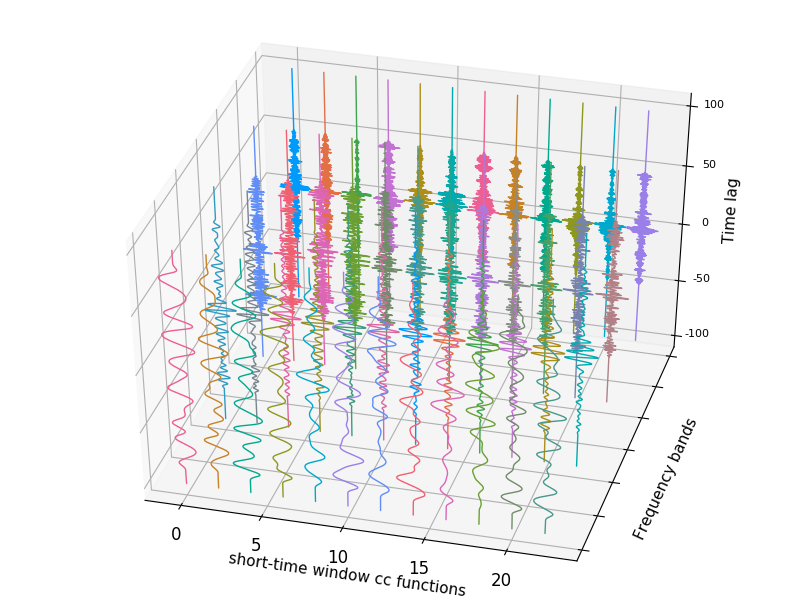

In [12]:
curdir = pwd()
include(curdir*"/utils/plot_wtcorr.jl")

fi = jldopen(Outputdir*"/"*"cc/$(year)_xcorrs.$(year).275.T00:00:00.jld2", "r")
C = fi["2004.275.T00:00:00/BP.VARB..BP1.BP.VCAB..BP1"]
close(fi)

plot_wtcorr(C, figdir=Outputdir*"/fig_wtcorr");

In [13]:

#===
5. Stacking
===#
if IsStack
    # compute stacking
    InputDict_stack = Dict(
                        "basefiname"      => Outputdir*"/cc/$(year)_xcorrs",
                        "Output_dir"      => Outputdir,
                        "timeunit"        => DL_time_unit,     # unit of time xcorrs are saved in. DL_time_unit if SeisDownload was used
                        "ref_starttime"   => starttime, # reference starttime to compute reference cross_correlation
                        "ref_endtime"     => endtime, # reference end to compute reference cross_correlation
                        "ref_iter"        => 1, # number of iteration for compute reference with selective_stacking
                        "stackmode"       => "selective", # selective, clustered_selective, linear
                        "compute_reference" => true, # compute reference or not; if you have computed reference, set false
                        "α0"                   => 0.1, # tapering percentage for lowest frequency band
                        "αmax"                 => 0.5, # tapering percentage for highest frequency band
                        "unitnumperstack"      => 1, # number of averaging unit (1 day-> 1 or 7 days = 7 with DLtimeunit=1)
                        "overlapperstack"      => 0, # overlap unit for averaging stack (>=0)
                        "corrtype"             => ["xcorr", "acorr"], # stacking correlation type
                        "freqband"             => freqband,
                        "starttime"            => starttime,
                        "endtime"              => endtime,
                        "filter"               => false, # applying bandpass filter before stacking (false or [fmin, fmax])
                        "IsNormalizedReference"=> false, # Normalizing amplitude of reference with deviding by its total num of stack
                        "IsNormalizedampperUnit"=> false, # Normalizing amplitude of xcorr by its maximum value per unit time (ex. each day)
                        "IsOutputRemovalFrac"   => false, # Output removal fraction; how long the signal is removed par unit download length
                        "fs"              => resamplingfrequency, # data sampling frequency
                        "maxlag"          => 100, # maximum time lag of xcorr
                        "metric"          => "cc", # cc:Pearson's corretion coffiecient, coh: cross coherence
                        "coh_win_len"     => 10.0, # Window length [s] when computing the psd using Welch's method. This parameter decides the resolvable frequencies in the coherence calculation
                        "coh_win_step"    => 5.0, # Step size [s] for windowing of each cross-correlation when computing the psd using Welch's method
                        "cohfilter"       => false, # filter when using metric "coh": false or [fmin fmax]
                        "threshold"       => 0.0, # threshold for selective stacking
                        "dtt_v"           => 1.0, # [km/s] false or Float64 for ballistic wave velocity
                        "savefig"         => true, # is save fig?
                        "figfmt"          => "png" # figure format
                      )

    st=time()
    seisstack(InputDict_stack)
    et=time()
    println("Stacking Successfully done in in $(et-st) seconds.");
end

In [ ]:
#===
6. dv/v analysis
===#
if IsDvV

    InputDict = Dict("basefiname"         => Outputdir,
                    "dvvmode"            => "absolutereference", # "absolutereference", ("inversion" not implemented)
                    "absolutereference"  =>  Outputdir*"/../reference_xcorr_for$(year).jld2", # absolute reference
                    "method"             => "Stretching",
                    "dtt_v"              => 1.3, # ballistic wave velocity[km/s]
                    "starttime"          => starttime,
                    "endtime"            => endtime,

                    # mwcs parameters
                    "fs"                 => resamplingfrequency,
                    "mintimelag"         => -100.0, #The leftmost time lag [s]
                    "window_length"      => 15.0, #moving window length
                    "window_step"        => 5.0,
                    "smoothing_half_win" => 5,
                    "dtt_lag"            => "dynamic",
                    "dtt_minlag"         => -100.0, # if dtt_lag = "static", use this as ballistic wave arrival
                    "dtt_width"          => 20.0,
                    "dtt_sides"          => "Both",

                    # stretching parameters
                    "ϵ_range"            => 0.2,
                    "ntrial"             => 200,
                    "Q_factor"           => 60,
                    "attenuation_minthreshold" => 0.1,
                    "max_coda_length"    => 60.0,
                    "min_ballistic_twin" => 5.0,
                    "plot_only_coda"     => false,
                    "plot_span"          => 4,
                    "IsPlotFigure"       => true
                    )

    st=time()
    SeisDvV.seisdvv(InputDict)
    et=time()
    println("Dv/v Successfully done in $(et-st) seconds.");
end



     _____        _             _             __
    / ____|      (_)           | |           / /
   | (___   ___   _   ___    __| |_   __    / /  __   __
    \___ \ / _ \ | | / __|  / _` \ \ / /   / /   \ \ / /
    ____) |  __/ | | \__ \ | (_| |\ V /   / /     \ V /
   |_____/ \___| |_| |___/  \__,_| \_/   /_/       \_/

                      _         _  _
                     | |       | |(_)           |
    __      __       | | _   _ | | _   __ _     | v1.2 (Last update 1/31/2020)
    \ \ /\ / /   _   | || | | || || | / _` |    | © Kurama Okubo
     \ V  V /_  | |__| || |_| || || || (_| |    |
      \_/\_/(_)  \____/  \__,_||_||_| \__,_|    |

Job start running at 2020-02-13T17:48:02.354



In [ ]:
#===
7. average dv/v
===#
if IsAveDvV
    InputDict = Dict(
                    "basefidir"        => Outputdir*"/../",        
                    "starttime"        => starttime, # start time of recording operation
                    "endtime"          => endtime, # end time of recording operation
                    "timeunit"         => 24*3600, # unit time to compute averaged dv/v

                    # cross-correlation type, channels and components
                    "corrtype"         => ["xcorr", "acorr"], # stacking correlation type
                    "components"       => ["11"], # stacking components
                    "freqband"         => [0.01, 0.1, 0.9, 1.2],
                    "minimumcount"     => 0, # minimum count of pairs which has cc > ccthreshold with stretching
                    "ccthreshold"      => 0.8, # threshold of correlation coefficient with stretching
                    "IsPlotFigure"     => true, # show figure to check station location
                    "figdir"           => Outputdir*"/fig_averaged_dvvcurve",
                    "Isoutputccstats"  => true,
                    "statsplotspan"    => 4,
                    )

    st=time()
    SeisNetwork.average_dvv(InputDict)
    et=time()
    println("Average Dv/v Successfully done in $(et-st) seconds.");
end

In [23]:
etall = time()
println("#--------------------------------------------#");
println("All requested processes have been successfully done.");
println("Total Computational time is $(etall-stall) seconds.");
println("#--------------------------------------------#");

#--------------------------------------------#
All requested processes have been successfully done.
Total Computational time is 2832.747055053711 seconds.
#--------------------------------------------#


RawData